#Trabajo Práctico 2

Redes neuronales recurrentes y Q-learning


##Problema 1 - Audio MNIST

**Descripción:**

En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a dígitos hablados del 0 al 9.

**Dataset:**

El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos, 50 clips por dígito por locutor.


###Librerias

In [73]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import librosa
import warnings
import glob
import sklearn.metrics
import os


###Cargar el dataset spoken_digit

In [74]:
# Cargar el dataset, dividir 'train' en train y validation
(train_ds, val_ds), ds_info = tfds.load(
    'spoken_digit',
    split=['train[:80%]', 'train[80%:]'], # 80% train, 20% validation
    shuffle_files=True,
    as_supervised=True,  # Retorna (audio, label) como tuplas
    with_info=True,      # Nos da la metadata
)

# Extraer los nombres de las etiquetas (serán '0', '1', ..., '9')
label_names = np.array(ds_info.features['label'].names)
print("Label names:", label_names)
print(ds_info)

Label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav
    files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the
    beginnings and ends.
    
    5 speakers\
    2,500 recordings (50 of each digit per speaker)\
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_dir='/root/tensorflow_datasets/spoken_digit/1.0.9',
    file_format=tfrecord,
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=int64),
        'audio/filename': Text(shape=(), dtype=string),
        'label'

###Preprocesamiento del Audio

In [75]:
# Definimos la longitud deseada (1 segundo a 8kHz)
TARGET_SAMPLES = 8000

# Función para preprocesar el audio
def preprocess_audio(waveform, label):
    # Convertir a float32
    waveform = tf.cast(waveform, tf.float32)

    # Obtener la longitud actual
    current_len = tf.shape(waveform)[0]

    if current_len < TARGET_SAMPLES:
        # Padding si es corto
        padding = tf.zeros([TARGET_SAMPLES - current_len], dtype=tf.float32)
        waveform = tf.concat([waveform, padding], 0)
    elif current_len > TARGET_SAMPLES:
        # Truncar si es largo
        waveform = waveform[:TARGET_SAMPLES]

    # Aseguramos la forma final (necesario para .map)
    waveform = tf.reshape(waveform, [TARGET_SAMPLES])

    return waveform, label

# Aplicamos el preprocesamiento a los datasets
train_audio_ds = train_ds.map(preprocess_audio, num_parallel_calls=tf.data.AUTOTUNE)
val_audio_ds = val_ds.map(preprocess_audio, num_parallel_calls=tf.data.AUTOTUNE)

# Optimizamos (puedes copiar .cache() .shuffle() .prefetch() de tu script)
train_audio_ds = train_audio_ds.cache().shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)
val_audio_ds = val_audio_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)

###Conversión a Espectrogramas

In [76]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

# Función para aplicar la transformación al dataset
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

# Creamos los datasets de espectrogramas
train_spectrogram_ds = make_spec_ds(train_audio_ds)
val_spectrogram_ds = make_spec_ds(val_audio_ds)

#Verificar la forma de entrada
for spec, label in train_spectrogram_ds.take(1):
    input_shape = spec.shape[1:]
print('Input shape:', input_shape)

Input shape: (61, 129, 1)


###Modelo 1 (CNN)

In [77]:
num_labels = len(label_names) # Esto será 10

# Adaptar la capa de Normalización (igual que en tu script)
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    # Downsample (opcional, pero ayuda a entrenar más rápido)
    tf.keras.layers.Resizing(32, 32),
    # Normalize
    norm_layer,
    # --- (Puedes usar la misma arquitectura de tu script) ---
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_labels),
])

model_cnn.summary()

# Compilar y entrenar (igual que en tu script)
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 20
history_cnn = model_cnn.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_4 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_8 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │       125,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,269 (563.55 KB)

 Trainable params: 144,266 (563.54 KB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.2924 - loss: 1.9584 - val_accuracy: 0.5880 - val_loss: 1.2610
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6660 - loss: 1.0725 - val_accuracy: 0.7120 - val_loss: 0.9939
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7652 - loss: 0.8424 - val_accuracy: 0.8100 - val_loss: 0.8453
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8381 - loss: 0.6172 - val_accuracy: 0.7940 - val_loss: 0.8278
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8425 - loss: 0.5697 - val_accuracy: 0.8620 - val_loss: 0.7587
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8779 - loss: 0.4701 - val_accuracy: 0.8500 - val_loss: 0.7172
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9086 - loss: 0.3660 - val_accuracy: 0.8700 - val_loss: 0.6375
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9071 - loss: 0.3571 - val_accuracy: 0.8820 - 

###Modelo 2 (RNN)

In [78]:
# Función para "aplastar" la última dimensión
def squeeze_dim(spectrogram, label):
    spectrogram = tf.squeeze(spectrogram, axis=-1)
    return spectrogram, label

# Creamos nuevos datasets para la RNN
# (Partimos de los datasets de espectrogramas que ya teníamos)
train_rnn_ds = train_spectrogram_ds.map(squeeze_dim, tf.data.AUTOTUNE)
val_rnn_ds = val_spectrogram_ds.map(squeeze_dim, tf.data.AUTOTUNE)

# Verificamos la nueva forma de entrada
for spec, label in train_rnn_ds.take(1):
    rnn_input_shape = spec.shape[1:]
print('RNN Input shape:', rnn_input_shape)

RNN Input shape: (61, 129)


####Construir el Modelo RNN

In [79]:
# Adaptar una nueva capa de Normalización para la forma (61, 128)
norm_layer_rnn = tf.keras.layers.Normalization()
norm_layer_rnn.adapt(data=train_rnn_ds.map(map_func=lambda spec, label: spec))

model_rnn = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=rnn_input_shape), # (61, 128)
    norm_layer_rnn,

    # Capa LSTM. Procesa la secuencia de 61 pasos
    tf.keras.layers.LSTM(64, return_sequences=True), # return_sequences=True si apilas otra RNN
    tf.keras.layers.LSTM(64),

    # Capas de clasificación (similares a la CNN)
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels),
])

model_rnn.summary()

# Compilar y entrenar
model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history_rnn = model_rnn.fit(
    train_rnn_ds,
    validation_data=val_rnn_ds,
    epochs=30,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_9 (Normalization) │ (None, 61, 129)        │           259 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 61, 64)         │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,557 (361.55 KB)

 Trainable params: 92,298 (360.54 KB)

 Non-trainable params: 259 (1.02 KB)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0916 - loss: 2.3148 - val_accuracy: 0.0840 - val_loss: 2.3036
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0891 - loss: 2.3082 - val_accuracy: 0.0900 - val_loss: 2.3044
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.0899 - loss: 2.3052 - val_accuracy: 0.1040 - val_loss: 2.3040
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.0954 - loss: 2.3061 - val_accuracy: 0.0900 - val_loss: 2.3073
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1158 - loss: 2.2993 - val_accuracy: 0.1300 - val_loss: 2.2590
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.1571 - loss: 2.1887 - val_accuracy: 0.1860 - val_loss: 1.9809
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1950 - loss: 2.0172 - val_accuracy: 0.2300 - val_loss: 1.8791
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2407 - loss: 1.9464 - val_accuracy: 0.3320 - v

###Comparación y Prueba Final

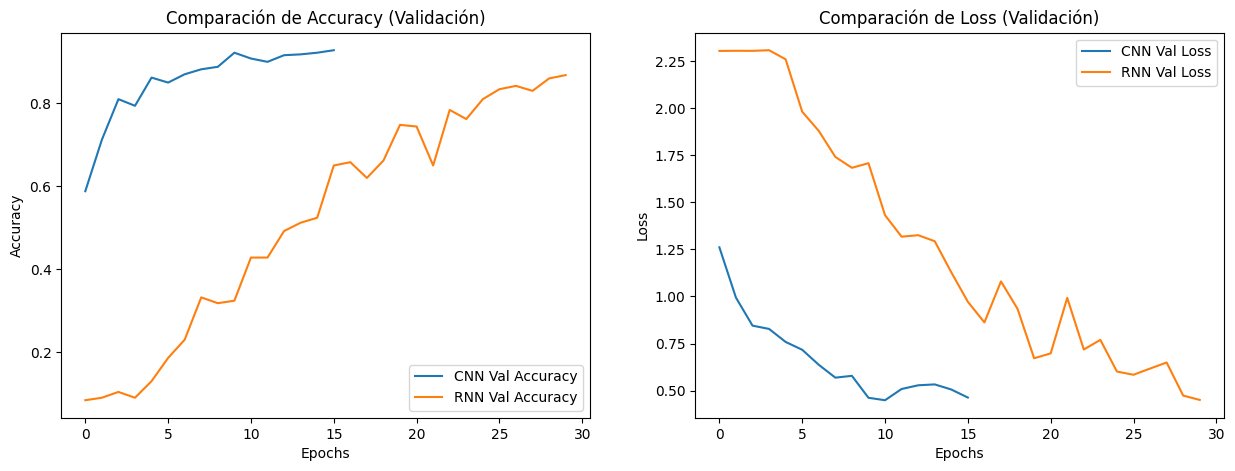

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step


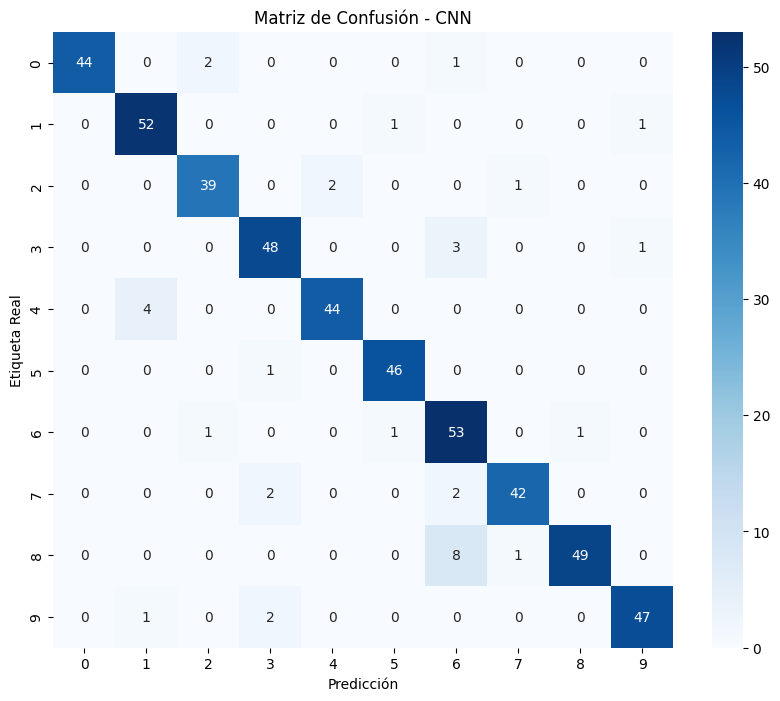

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


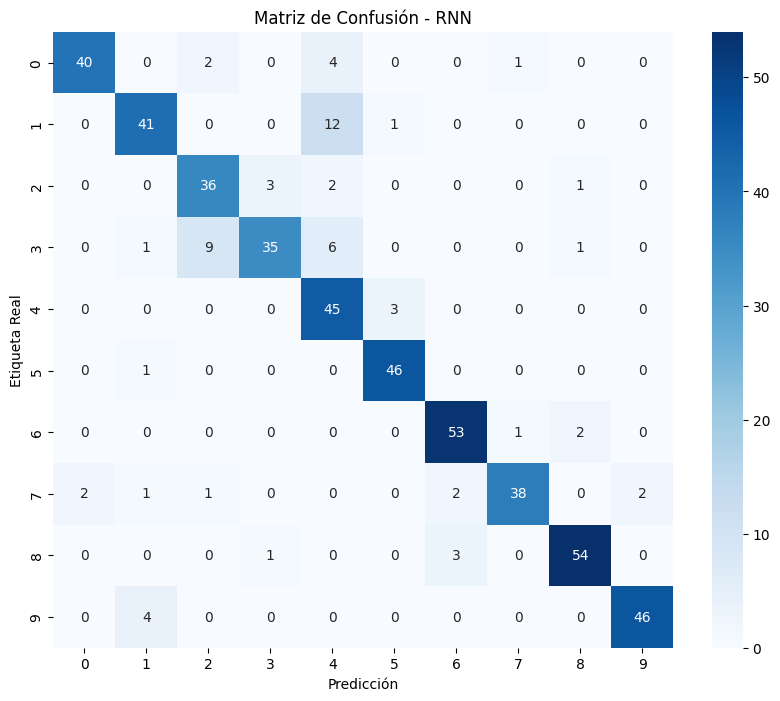

In [80]:

# --- 1. Gráficos de Entrenamiento (Loss y Accuracy) ---
def plot_history_comparison(hist_cnn, hist_rnn):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfico de Accuracy
    axes[0].plot(hist_cnn.history['val_accuracy'], label='CNN Val Accuracy')
    axes[0].plot(hist_rnn.history['val_accuracy'], label='RNN Val Accuracy')
    axes[0].set_title('Comparación de Accuracy (Validación)')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Gráfico de Loss
    axes[1].plot(hist_cnn.history['val_loss'], label='CNN Val Loss')
    axes[1].plot(hist_rnn.history['val_loss'], label='RNN Val Loss')
    axes[1].set_title('Comparación de Loss (Validación)')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.show()

# Llamamos a la función (asegúrate de haber entrenado ambos modelos antes)
plot_history_comparison(history_cnn, history_rnn)


# --- 2. Matriz de Confusión (Ejemplo con CNN) ---
def plot_confusion_matrix(model, dataset, title="Matriz de Confusión"):
    # Obtenemos predicciones y etiquetas reales
    y_pred_probs = model.predict(dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Extraemos las etiquetas reales del dataset (desempaquetando los batches)
    y_true = np.concatenate([y for x, y in dataset], axis=0)

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title(title)
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Predicción')
    plt.show()

# Generar matrices para ambos
plot_confusion_matrix(model_cnn, val_spectrogram_ds, "Matriz de Confusión - CNN")
# Nota: Para la RNN recuerda usar el dataset con dimensiones adecuadas (val_rnn_ds)
plot_confusion_matrix(model_rnn, val_rnn_ds, "Matriz de Confusión - RNN")

###Prueba de los modelos con aufios grabados

In [81]:
# Descargar el Dataset Propio
file_id = '1bHl34JdJD3lb1Te_E3Jes8vT2Ktm8KWr'
output_zip = 'mis_audios.zip'
output_folder = 'dataset_test_propio'

# Descargar usando gdown
!gdown --id {file_id} -O {output_zip}

# El flag -o sobreescribe archivos si ya existen
!unzip -o -q {output_zip} -d {output_folder}

print(f"Archivos descargados y descomprimidos en: {output_folder}")

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bHl34JdJD3lb1Te_E3Jes8vT2Ktm8KWr
To: /content/mis_audios.zip
100% 415k/415k [00:00<00:00, 135MB/s]
Archivos descargados y descomprimidos en: dataset_test_propio


In [82]:
# Ignoro las advertencias para mantener limpia la salida
warnings.filterwarnings('ignore')

# --- DEFINICIÓN DE FUNCIONES ---

# Función para procesar los audios y adaptarlos al formato del entrenamiento
def process_user_audio(file_path):
    # Cargo el audio forzando mono y 8kHz
    audio, sr = librosa.load(file_path, sr=8000, mono=True)

    # Elimino el silencio al principio y al final
    audio_trimmed, _ = librosa.effects.trim(audio, top_db=20)

    # Normalizo los picos para asegurar que el volumen sea consistente
    if np.max(np.abs(audio_trimmed)) > 0:
        audio_trimmed = audio_trimmed / np.max(np.abs(audio_trimmed))

    # Escalo los valores para simular el formato PCM int16 del dataset original
    audio_scaled = audio_trimmed * 32768.0

    # Ajusto la longitud a 8000 muestras (padding o recorte centrado)
    target_len = 8000
    current_len = len(audio_scaled)

    if current_len < target_len:
        pad_total = target_len - current_len
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        final_audio = np.pad(audio_scaled, (pad_left, pad_right), mode='constant')
    else:
        start = (current_len - target_len) // 2
        final_audio = audio_scaled[start : start + target_len]

    # Convierto a tensor y genero el espectrograma
    waveform = tf.convert_to_tensor(final_audio, dtype=tf.float32)
    spectrogram = get_spectrogram(waveform)
    spectrogram = spectrogram[tf.newaxis, ...] # Agrego dimensión de batch

    return spectrogram

# --- EJECUCIÓN DE PRUEBAS ---

# Inicializo contadores para las métricas globales
aciertos_cnn = 0
aciertos_rnn = 0
total_muestras = 0

# Lista para almacenar las filas de la tabla de resultados
filas_tabla = []

# Defino los prefijos de los archivos para ambos locutores
# N: Audios propios, M: Audios del compañero
prefijos_usuarios = ['N', 'M']

print(f"Iniciando evaluación de audios...")

# Itero sobre cada usuario y cada dígito
for prefijo in prefijos_usuarios:
    identificador_usuario = "Usuario 1" if prefijo == 'N' else "Usuario 2"

    for i in range(10):
        # Construyo el nombre del archivo esperado: Digitos_N_0.m4a, Digitos_M_0.m4a, etc.
        filename = f"Digitos_{prefijo}_{i}.m4a"

        # Busco el archivo en la estructura de carpetas descargada
        search_path = f"{output_folder}/**/{filename}"
        found_files = glob.glob(search_path, recursive=True)

        if not found_files:
            filas_tabla.append(f"{filename:<18} | {identificador_usuario:<10} | {'NO ENCONTRADO':<20}")
            continue

        full_path = found_files[0]

        try:
            # Obtengo el espectrograma procesado
            spec_cnn = process_user_audio(full_path)

            # Ajusto dimensiones para la RNN (elimino la dimensión de canales)
            spec_rnn = tf.squeeze(spec_cnn, axis=-1)

            # Obtengo la predicción del modelo CNN
            pred_cnn = model_cnn.predict(spec_cnn, verbose=0)
            label_cnn = label_names[np.argmax(pred_cnn)]

            # Obtengo la predicción del modelo RNN
            pred_rnn = model_rnn.predict(spec_rnn, verbose=0)
            label_rnn = label_names[np.argmax(pred_rnn)]

            # Comparo con la etiqueta real (el dígito i)
            etiqueta_real = str(i)
            match_cnn = "✅" if label_cnn == etiqueta_real else "❌"
            match_rnn = "✅" if label_rnn == etiqueta_real else "❌"

            # Actualizo los contadores de precisión
            if label_cnn == etiqueta_real:
                aciertos_cnn += 1
            if label_rnn == etiqueta_real:
                aciertos_rnn += 1
            total_muestras += 1

            # Agrego la fila con los resultados a la lista
            fila = f"{filename:<18} | {label_cnn:<6} {match_cnn:<3} | {label_rnn:<6} {match_rnn:<3} | {etiqueta_real:<4}"
            filas_tabla.append(fila)

        except Exception as e:
            filas_tabla.append(f"Error en {filename}: {e}")

# --- VISUALIZACIÓN DE RESULTADOS ---

print(f"\n{'='*65}")
print(f"{'Archivo':<18} | {'CNN':<10} | {'RNN':<10} | {'Real':<4}")
print(f"{'-'*65}")

for fila in filas_tabla:
    print(fila)

print(f"{'='*65}")

# Calculo y muestro el resumen estadístico final
if total_muestras > 0:
    acc_cnn = (aciertos_cnn / total_muestras) * 100
    acc_rnn = (aciertos_rnn / total_muestras) * 100

    print(f"\nResumen de Desempeño Global:")
    print(f"Total de audios evaluados: {total_muestras}")
    print(f"Precisión Modelo CNN:      {acc_cnn:.1f}%  ({aciertos_cnn}/{total_muestras})")
    print(f"Precisión Modelo RNN:      {acc_rnn:.1f}%  ({aciertos_rnn}/{total_muestras})")
else:
    print("\nNo se encontraron audios para evaluar.")

Iniciando evaluación de audios...

Archivo            | CNN        | RNN        | Real
-----------------------------------------------------------------
Digitos_N_0.m4a    | 2      ❌   | 0      ✅   | 0   
Digitos_N_1.m4a    | 0      ❌   | 1      ✅   | 1   
Digitos_N_2.m4a    | 7      ❌   | 0      ❌   | 2   
Digitos_N_3.m4a    | 7      ❌   | 9      ❌   | 3   
Digitos_N_4.m4a    | 9      ❌   | 4      ✅   | 4   
Digitos_N_5.m4a    | 4      ❌   | 9      ❌   | 5   
Digitos_N_6.m4a    | 8      ❌   | 9      ❌   | 6   
Digitos_N_7.m4a    | 7      ✅   | 0      ❌   | 7   
Digitos_N_8.m4a    | 9      ❌   | 3      ❌   | 8   
Digitos_N_9.m4a    | 4      ❌   | 0      ❌   | 9   
Digitos_M_0.m4a    | 3      ❌   | 0      ✅   | 0   
Digitos_M_1.m4a    | 0      ❌   | 0      ❌   | 1   
Digitos_M_2.m4a    | 9      ❌   | 2      ✅   | 2   
Digitos_M_3.m4a    | 6      ❌   | 9      ❌   | 3   
Digitos_M_4.m4a    | 0      ❌   | 1      ❌   | 4   
Digitos_M_5.m4a    | 9      ❌   | 2      ❌   | 5   
Digitos_M_6.m4a